## Figure 2: Commissure ratio against MS

Create one or two figures showing the relationship with biomarkers (such as commisural ratio) and MS, comparing it between groups
and against EDSS/SDMT

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statannot import add_stat_annotation
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy import stats
from statannotations.Annotator import Annotator
import itertools 

# ignore warnings for easier plotting
import warnings
warnings.filterwarnings("ignore")

from load_data import load_data

In [7]:
sns.set(style='darkgrid', context='talk', palette='Set1', font="serif")

In [8]:
# Hue colors order and names
# auxiliar dict to put correct order in the figure
map_hue_color = {
    "EDSS_group": ["EDSS<=3", "EDSS>3"],
    "SDMT_group": ["SDMT>=40", "SDMT<40"],
    "G_norm": ['G_z<=0', 'G_z>0'], 
    "Corr_norm": ['C_z<=0', 'C_z>0'],
    "disease": ["HC", "MS"],
    "GROUP": ["HC", "CIS", "RRMS", "SPMS", "PPMS"],
    "CENTER": ["CLINIC", "MAINZ", "MILAN", "NAPLES", "OSLO", "LONDON", "AMSTERDAM"],
    "groups" : ["HC", "EDSS<=3", "EDSS>3", "SDMT>=40", "SDMT<40"]
    # "GROUP": ["HC", "RRMS", "SPMS", "PPMS"]
}

# get the progressives together.
mapping_prog = {
    "HC": "HC",
    "CIS": "CIS", 
    "RRMS": "RRMS", 
    "SPMS": "PMS", 
    "PPMS": "PMS"
}

df_merged = load_data()
print(df_merged.columns.values)

['SubjID' 'DOB' 'SEX' 'GROUP' 'ONSET_DATE' 'MR_DATE' 'TREATMENT_AT_MRI'
 'TREATMENT' 'EDSS' 'YED' 'SDMT' 'RAO_SRTS' 'RAO_SRTR' 'RAO_SRTD'
 'RAO_10_36_SRTR' 'RAO_10_36_SRTD' 'RAO_WLG' 'RAO_PASAT' 'CENTER'
 'FMRI_TR' 'FMRI_NSCANS' 'FMRI_SCANTIME' 'AGE' 'DD' 'BICAMS_CVLT2'
 'BICAMS_BVMTR' 'NPS_x' '9HPT_dH' '9HPT_ndH' 'T25FW' 'motor_x'
 'Datecognitiveevaluation' 'TypeRAO' 'RAO_PASAT2sec'
 'RAO_WLGperseveration' 'RAO_WLGintrusion' 'Right9HPT' 'Left9HPT'
 'MFIS_TOTAL' 'MFIS_PHYS_FUNCT' 'MFIS_COGN_FUNCT' 'MFIS_SOCIAL_FUNCT'
 'BDI_II' '9HPT_average' 'notes_NPS' '9HPT_dH_' 'DWI_PROT' 'SCANNER'
 'SRTL_sum' 'PASAT2' 'WRDLG' 'QC' 'CENTER2' 'GM' 'GMF' 'WM' 'WMF' 'CSF'
 'CSFF' 'LV' 'LVF' 'BPF' 'RDwm_mean' 'RDwm_std' 'RDlwm_mean' 'RDlwm_std'
 'RDl_mean' 'RDl_std' 'RD_gm' 'RD_gmwm' 'Meta_x' 'Meta_noreg'
 'Unnamed: 21' 'Unnamed: 22' 'Unnamed: 23' 'FAwm_mean' 'FAwm_std'
 'FAlwm_mean' 'FAlwm_std' 'FAl_mean' 'FAl_std' 'FA_gm' 'FA_gmwm'
 'CC_Sag_area' 'CC_Posterior' 'CC_Mid_Posterior' 'CC_Central'
 'CC_Mid

In [9]:
to_correct_for = 'AGE + C(CENTER) + C(SEX)'

x1 = "Comm_ratio"
x2 = "CC_ratio_area"
x3 = "SC_spl_full"
x4 = "SC_eff_full"

results = smf.ols(f'{x1} ~ {to_correct_for}', data=df_merged).fit()
df_merged[f"{x1}"] = results.resid + results.params.Intercept
results = smf.ols(f'{x2} ~ {to_correct_for}', data=df_merged).fit()
df_merged[f"{x2}"] = results.resid + results.params.Intercept
results = smf.ols(f'{x3} ~ {to_correct_for}', data=df_merged).fit()
df_merged[f"{x3}"] = results.resid + results.params.Intercept
results = smf.ols(f'{x4} ~ {to_correct_for}', data=df_merged).fit()
df_merged[f"{x4}"] = results.resid + results.params.Intercept

results = smf.ols(f'EDSS ~ {to_correct_for}', data=df_merged).fit()
df_merged[f"EDSS"] = results.resid + results.params.Intercept

results = smf.ols(f'SDMT ~ {to_correct_for}', data=df_merged).fit()
df_merged[f"SDMT"] = results.resid + results.params.Intercept


p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

HC vs. EDSS<=3: t-test independent samples, P_val:5.598e-06 t=4.590e+00
EDSS<=3 vs. EDSS>3: t-test independent samples, P_val:2.856e-01 t=-1.069e+00
SDMT>=40 vs. SDMT<40: t-test independent samples, P_val:2.455e-07 t=5.235e+00
HC vs. EDSS>3: t-test independent samples, P_val:5.665e-04 t=3.466e+00
HC vs. SDMT>=40: t-test independent samples, P_val:6.717e-06 t=4.543e+00
HC vs. SDMT<40: t-test independent samples, P_val:2.547e-13 t=7.648e+00
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

HC vs. EDSS<=3: t-test independent samples, P_val:3.022e-09 t=6.039e+00
EDSS<=3 vs. EDSS>3: t-test independent samples, P_val:1.800e-01 t=-1.342e+00
SDMT>=40 vs. SDMT<40: t-test independent sampl

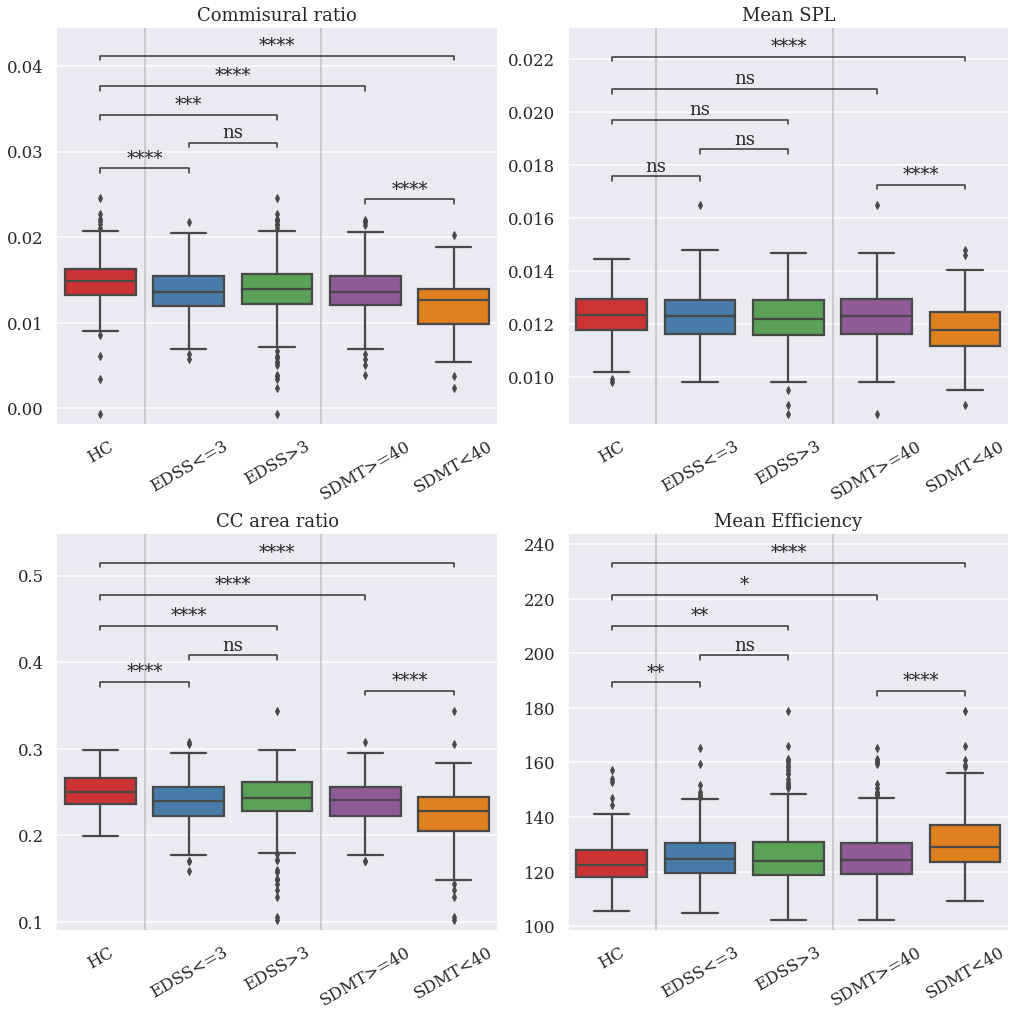

In [10]:
def create_dataframe_categories(df):
    """
    Create the dataframe with the new category and 
    return it
    """

    var_name = "groups"

    df_HC = df[df.GROUP == "HC"]
    df_HC[var_name] = "HC"

    df_lowEDSS = df[df.EDSS_group == "EDSS<=3"]
    df_highEDSS = df[df.EDSS_group == "EDSS>3"]

    df_lowEDSS[var_name] = "EDSS<=3"
    df_highEDSS[var_name] = "EDSS>3"

    # For the SDMT, remember not to include HC 
    df_lowSDMT = df[(df.SDMT_group == "SDMT<40") & (df.GROUP != "HC")]
    df_highSDMT = df[(df.SDMT_group == "SDMT>=40") & (df.GROUP != "HC")]

    df_lowSDMT[var_name] = "SDMT<40"
    df_highSDMT[var_name] = "SDMT>=40"

    # Concatenate all of the dfs
    df_out = pd.concat([df_HC, df_lowEDSS, df_highEDSS, df_lowSDMT, df_highSDMT])
    return df_out

df_merged = create_dataframe_categories(df_merged)

## Boxplot differences across groups
# paper
f, axes = plt.subplots(2, 2, figsize=(14,14), constrained_layout=True)

## left G, right cs
statest = "t-test_ind" # Mann-Whitney t-test_ind
axes = axes.T.ravel()
group_pairs = [("HC", "EDSS<=3"), ("HC", "EDSS>3"), ("HC", "SDMT<40"), ("HC", "SDMT>=40"), ("EDSS<=3", "EDSS>3"), ("SDMT<40", "SDMT>=40")]

# set vertical lines dividing categories
for ax in axes:
    ax.axvline(0.5, c="#C0C0C0", lw=1.5)
    ax.axvline(2.5, c="#C0C0C0", lw=1.5)
    ax.set_xticklabels(ax.get_xticklabels(),rotation = 30)

# Average G
sns.boxplot(data=df_merged, x="groups", y=x1, order=map_hue_color["groups"], orient="v", ax=axes[0])
annotator = Annotator(axes[0], group_pairs, orient='v', data=df_merged, x="groups", y=x1, order=map_hue_color["groups"], verbose=1)
annotator.configure(test=statest, text_format='star', loc='inside')
annotator.apply_and_annotate()
axes[0].legend([],[], frameon=False)
axes[0].set_title("Commisural ratio")
axes[0].set(xlabel=None)
axes[0].set(ylabel=None)

# Individual G
sns.boxplot(data=df_merged, x="groups", y=x2, order=map_hue_color["groups"], orient="v", ax=axes[1])
annotator = Annotator(axes[1], group_pairs, orient='v', data=df_merged, x="groups", y=x2, order=map_hue_color["groups"], verbose=1)
annotator.configure(test=statest, text_format='star', loc='inside')
annotator.apply_and_annotate()
axes[1].legend([],[], frameon=False)
axes[1].set_title("CC area ratio")
axes[1].set(xlabel=None)
axes[1].set(ylabel=None)

# Average osc G
sns.boxplot(data=df_merged, x="groups", y=x3, order=map_hue_color["groups"], orient="v", ax=axes[2])
annotator = Annotator(axes[2], group_pairs, orient='v', data=df_merged, x="groups", y=x3, order=map_hue_color["groups"], verbose=1)
annotator.configure(test=statest, text_format='star', loc='inside')
annotator.apply_and_annotate()
axes[2].legend([],[], frameon=False)
axes[2].set_title("Mean SPL")
axes[2].set(xlabel=None)
axes[2].set(ylabel=None)

# Individual osc G
sns.boxplot(data=df_merged, x="groups", y=x4, order=map_hue_color["groups"], orient="v", ax=axes[3])
annotator = Annotator(axes[3], group_pairs, orient='v', data=df_merged, x="groups", y=x4, order=map_hue_color["groups"], verbose=1)
annotator.configure(test=statest, text_format='star', loc='inside')
annotator.apply_and_annotate()
axes[3].legend([],[], frameon=False)
axes[3].set_title("Mean Efficiency")
axes[3].set(xlabel=None)
axes[3].set(ylabel=None)

#plt.tight_layout()

plt.savefig("/home/gerard/PAPERS/PAPER_COBRA/FIGURES/boxplot_final.pdf", dpi=300)
plt.savefig("/home/gerard/PAPERS/PAPER_COBRA/BRAIN_SUBMISSION/FIGURES/Fig3_boxplot_final.png", dpi=300)